# A Recurrent Network Mechanism of Time Integration in Perceptual Decisions
Wong,  Wang
Journal of Neuroscience, January 2006, 26(4):1212-1328

## Modelling Heading Perception in a Vestibular Discimination Experiment using a Recurent Network Mechanism

Sensory information regarding self-motion through an environment is gathered by the vestibular system. This model describes how two neural populations, tuned to different heading directions, facilitate the decision-making process wherein one recognises the leftward or rightward direction of their self-motion. This study builds upon the modelling work of Wang (2006) and the experimental results of Butler (2010).  

## The two-variable network model for heading discrimination 

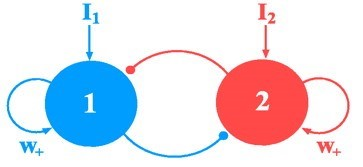


The figure above, from Wang (2006), depicts the system being modelled. We start with a communicating pair of neural populations, population $1$ shown in blue and population $2$ in red, are sensitive to leftward or rightward heading motion respectively. Each population is auto-excitatory, depicted by the recurrent $W_+$ connections, and extra-inhibitory, shown by the interrelated connections. The system is fed by two inputs, $I_1$ and $I_2$, from the MSTd area which has been found to relay momentary vestibular and visual self-motion information for heading discrimination to the LIP area, Hou et. al. (2019).  

## Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


## Defining functions

### Firing Rate

The firing rate $r_i$ of population $1$ or $2$ is found by;  

$$r_1 = H_1(x_1,x_2),$$
$$r_2 = H_2(x_1,x_2),$$

where $H_i$ is an input-output relation adapted from Abbot and Chance (2005) and $x_i$ is the total synaptic current accounting for all recurrent and external inputs. Recurrent inputs consist of both excitatory and inhibitory currents.

### Total Synaptic Current

In this reduced system, the total synaptic current is comprised of recurrent and external inputs to populations $1$ and $2$ and is described by the following equations for $x_1$ and $x_2$;  
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1},$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,2}.$$  

<b>External inputs:</b>  
$I_{0}$ - common background input to both populations set to constant $0.3255 nA$   
$I_i$ - motion information from MSTd area, dependant on heading angel (equation ??)  
$I_{noise,i}$ - noise term added for charateristic Ornstein-Uhlenbeck process of evidence accumulation (equation ??)  

<b>Recurrent inputs:</b>   
Communication between both populations are dependant upon the dominant synaptic gating variable of the recipient population, either $S_1$ or $S_2$ whose evolution are defined in equation (???).    
Synaptic couplings, $J_{i,j}$, define the connectivity between population $i$ and $j$. Wang (2006) recomends values of $J_{11}=0.2609 =J_{22}$ and $J_{12}=0.0497= J_{21}$ based off Roitman and Shadlan (2002). These paprameter values may not be optimal for other simulations. 

In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2


### Input-Output Relation

The population firing rate is found as a function of the input currents defined above in $x_i$. Parameters $a, b$ and $d$ correspond to the gain factor, threshold potential and noise factor respectivly. 

$$ H_i(x_i)=\frac{a x_i-b}{(1-exp[-d(ax_i-b)]}$$

#### Parameter values of $H_i$
$ a=207 (VnC)^{-1}; \:\:  b=108Hz; \:\:d=0.154s$

In [2]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(-1,1,0.01)


### Synaptic Gating Variables
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$




This equation describes the change in $S_i$, the synaptic gating variable, of the system i.e. the opening and closing of ion channels. It governs the time evolution of the system and is dependant upon the synaptic gating variable, $S_i$, and it's decay time constant, $\tau_S$, as well as the population activity measure, $H(x_i)$ described above. 

#### Approximated below using Heun's method: 
Heun's Method: $y_{i+1} = y_{i} + \frac{h}{2}(f(y_i) + f(y_i + hf(y_i)))$

$$k=h(-\frac{S}{\tau_S}+(1-S)\gamma H(x)$$
$$S_{new}=S_i+h(-\frac{S+\frac{k_1}{2}}{\tau_S}+(1-S+\frac{k}{2})\gamma H(x)$$

#### Parameter values
$\tau_S=0.1s;  \gamma=0.641$

In [5]:
def Network_Dynamics(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.1#100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x))
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

### External Input 

The inputs to our decision making populations should mimic the output from upstream areas for heading information encoding. The MSTd region has been identified as a potential neural basis of multimodal heading perception, and is thus far the most extensivly studied neural substrate for visual–vestibular cue integration, DeAngelis and Angelaki (2012). 


Strength and direction of the stimulius motion are defined by the value and sign of cohearence, $c'$.

$$ I_1=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$
$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

#### Parameter values for both directions are the same
$ \mu_0= 30 Hz; J_{A,ext}= 5.2 × 10^{−4} nA · Hz^{−1} $


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

In [7]:
def I_input_2(c_dash):
    J_A_ext=5.2/10000  # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

### Background activity

The stochastic motion typical of evidence accumulation in a diffusion model is added to the system by means of the following equation;

$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise},$$  

a Ornwtein-Uhlenbeck process where $I_{noise,i}$ is the input noise term, $\sigma^2_{noise}$ is it's varience and $\eta$ is a Gaussian white noise with zero mean and unit varience. 

#### Background activity is approximated in the code below using Euler's method 
$$ I_{noise,i+1}=I_{noise,i}+\frac{h}{\tau_{AMPA}}(-I_{noise,i}+\eta_i\sqrt{\tau_{AMPA}}\sigma)$$  


#### Parameter values
$ \tau_{AMPA}=2ms; \:\: \sigma_{noise}=0.02nA  $

In [4]:
def Background_Activity(I_noise):
    h=0.1
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=np.random.normal(0,1,1) #Gaussian white noise
    I_noise_new=I_noise+h/tau_AMPA*(-I_noise+eta_noise*np.sqrt(tau_AMPA)*sigma_noise) #numerical approximation
    return I_noise_new

## Material and Methods

### Initialisation of variables

Parameter values set as per appexdix directions of Wang (2006), based on fitting of data from Roitman and Shadlen (2002).

In [8]:
h=0.1
time=np.arange(-100,1000,h)
J_A_ext=5.2/10000 # nA/Hz
mu_0=30 # Hz
#Vector_heading=[1.0,3.0,5.0,7.5,10.0,15.0]
#Vector_heading=[7.0,10.0]
Vector_heading=[-20.0,-10.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,10.0,20.0]

Threshold=15
N=200
RT_coh_right=np.zeros(len(Vector_heading))
RT_coh_left=np.zeros(len(Vector_heading))

RT_avg=np.zeros(len(Vector_heading))

Prob=np.zeros(len(Vector_heading))
count=0
#fig = plt.figure(figsize=(12,8))

ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_1=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_2=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
Firing_target_1=0*time # np.zeros((1,len(time)))
Firing_target_2=0*time # np.zeros((1,len(time)))

### Generating response and reaction times 

In [9]:
for j in range(0,len(Vector_heading)):
    ANSWER=np.zeros(N)
    RT=np.zeros(N)


    for n in range(0,N):
        if n%500==0:
               print('Heading= %2.2f , n= %d' %(Vector_heading[j],n))
        I_noise_1=0.001*np.random.normal(0,1,len(time))
        I_noise_2=0.001*np.random.normal(0,1,len(time))

        x_1=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_2=J_A_ext*mu_0*np.random.uniform(0,1,len(time))

        S_1=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
        S_2=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

 

        Firing_target_1[0]=H(x_1[0])
        Firing_target_2[0]=H(x_2[0])


        count=0
        for i in range (0,len(time)-1):
            if time[i] >=0 and time[i]<1000:
                c_dash=Vector_heading[j]
            else:
                c_dash=0.0

        
            I_noise_1[i+1]=Background_Activity(I_noise_1[i])
            I_noise_2[i+1]=Background_Activity(I_noise_2[i])

            I_1[i+1]=I_input_1(c_dash)
            I_2[i+1]=I_input_2(c_dash)

            x_1[i+1],x_2[i+1]=total_synaptic_current(S_1[i],S_2[i],I_1[i],I_2[i],I_noise_1[i],I_noise_2[i])
            S_1[i+1]=Network_Dynamics(S_1[i],x_1[i+1])
            S_2[i+1]=Network_Dynamics(S_2[i],x_2[i+1])
            Firing_target_1[i]=H(x_1[i])
            Firing_target_2[i]=H(x_2[i])

            #if count ==1:
                #break
                
            if count <0.5:
                if Firing_target_1[i] >=Threshold: 
                    ANSWER[n]=1
                    RT[n]=time[i]
                    count=1
                if Firing_target_2[i] >=Threshold:
                    ANSWER[n]=0
                    RT[n]=time[i]
                    count=1
            
                
        if count <0.5:
            if Firing_target_1[i] >=Firing_target_2[i]: 
                ANSWER[n]=1
                RT[n]=time[-1]
            else:
                ANSWER[n]=1
                RT[n]=time[-1]
                                    
    
    Prob[j]=np.average(ANSWER)
    RT_coh_right[j]=np.average(RT[ANSWER==1])
    RT_coh_left[j]=np.average(RT[ANSWER==0])

    RT_avg[j]=np.average(RT)

Heading= -20.00 , n= 0
Heading= -10.00 , n= 0
Heading= -5.00 , n= 0
Heading= -3.00 , n= 0
Heading= -1.00 , n= 0
Heading= 1.00 , n= 0
Heading= 3.00 , n= 0
Heading= 5.00 , n= 0
Heading= 10.00 , n= 0
Heading= 20.00 , n= 0


### Plotting
Plot of Firing Rate, $H(X_i)$, evolution with time. When either the left or rightward prefrenced population firing rate reaches the threshold, a decision is made.   

Ideally, the code would stop here and continue to the next trial. Have to add that in. 

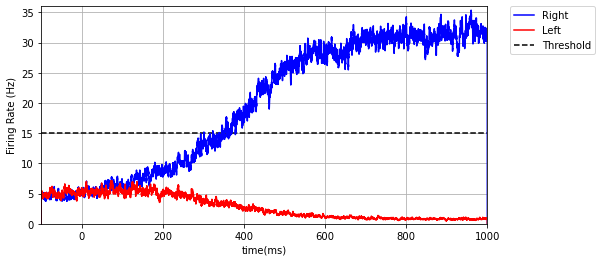

In [26]:
fig = plt.figure(figsize=(8,4))

plt.plot(time,Firing_target_1,'-',color='blue',label="Right")
plt.plot(time,Firing_target_2,'-',color='red',label="Left")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
plt.xlim((-100,1000))
plt.ylim((0,36))
plt.hlines(Threshold,-100,1000,color='black',linestyles='dashed',label="Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('Example_Firing_Pattern.png', bbox_inches='tight',dpi=300)

# plt.
#plt.ylim((30,50))
plt.show()


#### Fitting

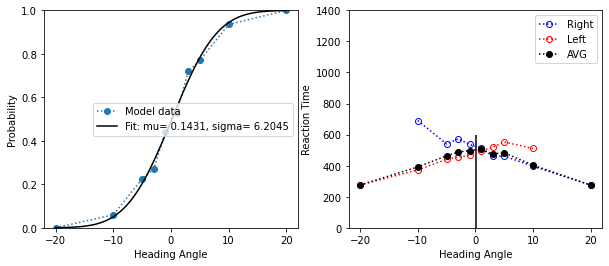

In [13]:
from scipy.optimize import curve_fit
from scipy.stats import norm

mu,sigma=curve_fit(norm.cdf,Vector_heading,Prob,p0=[0,1])[0]  # fitting the curve cumulative normal (norm.cdf)
                                                                # takes estimate for mean-mu and sd-sigma from experiment
    #vector_heading has 10 elements, vector_hed has 400

#Plotting    
fig = plt.figure(figsize=(10,4))

plt.subplot(121) # lhs heading & Prob (1=right,0=left)
plt.plot(Vector_heading,Prob,'o:',label='Model data') # plotting prob of answering left or right vs 10 heading directions
Vector_hed=np.arange(-20,20,0.1) #list of 400 numbers from -20.0 to 19.9
plt.plot(Vector_hed,norm.cdf(Vector_hed,mu,sigma),'k',label='Fit: mu= %2.4f, sigma= %2.4f'% (mu,sigma)) #fitting a cumulative distibution based on experiment data
plt.legend()
plt.xlabel('Heading Angle')
plt.ylabel('Probability')
plt.ylim(0,1)


plt.subplot(122)
plt.plot((Vector_heading),RT_coh_right,'o:',fillstyle='none',color='blue',label="Right")
plt.plot((Vector_heading),RT_coh_left,'o:',fillstyle='none',color='red',label="Left")
plt.plot((Vector_heading),RT_avg,'o:',color='black',label="AVG")
plt.vlines(mu,0,600,color='black')

plt.legend()
plt.ylim(0,1400)
plt.xlabel('Heading Angle')
plt.ylabel('Reaction Time')
plt.savefig('Visual Heading Behavioural.png', bbox_inches='tight',dpi=300)

plt.show()

The LHS figure, shows a cumulative gaussian function fit to a plot of the proportion of rightward choices as a function of heading angle. Both the mean (mu) and standard deviation (sigma) were calculated from this fit. The mean is close to 0, as expected due to the identical number of leftward and rightward trials. The standard deviation is proportional to the steepness of the curve and so here, it is a measure of trial average preformance on correctness for each heading direction.   

The RHS figure indicates Reaction time as a function of heading direction. Incorrect responses are shown to have longer reaction times in both directions. The average RT by heading angle closly follows the correct responses due to the realitivly small number of incorrect responses.     

Want to see the relationship between mu and sigma of the choice & RT data. Can unisensory heading trial choice data predict RTs? 

# Reference
Butler, J. S., Smith, S. T., Campos, J. L., & Bülthoff, H. H. (2010). Bayesian integration of visual and vestibular signals for heading. Journal of vision, 10(11), 23-23.

Gu, Y., Angelaki, D. E., & DeAngelis, G. C. (2008). Neural correlates of multisensory cue integration in macaque MSTd. Nature neuroscience, 11(10), 1201-1210.  

Wong KF, Wang XJ. A recurrent network mechanism of time integration in perceptual decisions. J Neurosci. 2006 Jan 25;26(4):1314-28. doi: 10.1523/JNEUROSCI.3733-05.2006. PMID: 16436619; PMCID: PMC6674568.

Han Hou, Qihao Zheng, Yuchen Zhao, Alexandre Pouget, Yong Gu (2019)
Neural Correlates of Optimal Multisensory Decision Making under Time-Varying Reliabilities with an Invariant Linear Probabilistic Population Code, Neuron, Volume 104, Issue 5, Pages 1010-1021.e10

DeAngelis GC, Angelaki DE. Visual–Vestibular Integration for Self-Motion Perception. In: Murray MM, Wallace MT, editors. The Neural Bases of Multisensory Processes. Boca Raton (FL): CRC Press/Taylor & Francis; 2012. Chapter 31. Available from: https://www.ncbi.nlm.nih.gov/books/NBK92839/